In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import re
import glob
import pickle
import numpy
import tqdm
from scipy.misc import logsumexp
from scipy import interpolate
from galpy.potential import MWPotential2014, LogarithmicHaloPotential
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.actionAngle import actionAngleTorus
from galpy.orbit import Orbit
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_conversion, bovy_coords, save_pickles
import seaborn as sns
import MWPotential2014Likelihood
import pal5_util
import gd1_util
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
ro, vo= _REFR0, _REFV0
import corner
%pylab inline
from matplotlib import cm, gridspec
from matplotlib.ticker import NullFormatter
import copy
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Exploration of the Milky Way's dark halo shape using the GD-1 stream

## The data

In [3]:
posdata,distdata,pmdata,rvdata= gd1_util.gd1_data()

## Some convenience functions

In [4]:
def plot_data_add_labels(color=sns.color_palette()[2],
                        p1=(1,4,1),p2=(1,4,2),p3=(1,4,3),p4=(1,4,4),
                        noxlabel=False,ylabel_as_text=False,noylabel=False,
                        nopm=False):
    if noxlabel: nullfmt= NullFormatter()
    subplot(*p1)
    if not noxlabel: xlabel(r'$\phi_1\,(\mathrm{degree})$')
    else: gca().xaxis.set_major_formatter(nullfmt)
    if not noylabel:
        if not ylabel_as_text: ylabel(r'$\phi_2\,(\mathrm{degree})$')
        else: bovy_plot.bovy_text(r'$\phi_2\,(\mathrm{degree})$',top_right=True,size=17.)
    xlim(-80.,20.)
    ylim(-4.,2.)
    bovy_plot._add_ticks()
    errorbar(posdata[:,0],posdata[:,1],yerr=posdata[:,2],
             ls='none',marker='o',color=color)
    subplot(*p2)
    if not noxlabel: xlabel(r'$\phi_1\,(\mathrm{degree})$')
    else: gca().xaxis.set_major_formatter(nullfmt)
    if not noylabel:
        if not ylabel_as_text: ylabel(r'$\mathrm{Distance}\,(\mathrm{kpc})$')
        else: bovy_plot.bovy_text(r'$\mathrm{Distance}\,(\mathrm{kpc})$',top_right=True,size=17.)
    xlim(-80.,20.)
    ylim(5.,15.)
    bovy_plot._add_ticks()
    errorbar(distdata[:,0],distdata[:,1],yerr=distdata[:,2],
             ls='none',marker='o',color=color)
    if not nopm:
        subplot(*p3)
        if not noxlabel: xlabel(r'$\phi_1\,(\mathrm{degree})$')
        else: gca().xaxis.set_major_formatter(nullfmt)
        if not noylabel:
            if not ylabel_as_text: ylabel(r'$\mu_{\phi}}\,(\mathrm{mas\,yr}^{-1})$')
            else: bovy_plot.bovy_text(r'$\mu_{\phi}}\,(\mathrm{mas\,yr}^{-1})$',top_right=True,size=17.)
        xlim(-80.,20.)
        ylim(-15.,5.)
        bovy_plot._add_ticks()
        errorbar(pmdata[:,0],pmdata[:,1],yerr=pmdata[:,3],
                 ls='none',marker='o',color=color)
        errorbar(pmdata[:,0],pmdata[:,2],yerr=pmdata[:,3],
                 ls='none',marker='o',color=color)
    subplot(*p4)
    if not noxlabel: xlabel(r'$\phi_1\,(\mathrm{degree})$')
    else: gca().xaxis.set_major_formatter(nullfmt)
    if not noylabel:
        if not ylabel_as_text: ylabel(r'$V_{\mathrm{los}}\,(\mathrm{km\, s}^{-1})$')
        else: bovy_plot.bovy_text(r'$V_{\mathrm{los}}\,(\mathrm{km\, s}^{-1})$',top_right=True,size=17.)
    xlim(-80.,20.)
    ylim(-350.,200.)
    bovy_plot._add_ticks()
    errorbar(rvdata[:,0],rvdata[:,2],yerr=rvdata[:,3],
             ls='none',marker='o',color=color)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025,0.78])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



## A first model

In [5]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
# These values are the best-fit we've found for p_b15
p= [1.22546174,1.01826231,-0.87622245,1.00457819,-0.07508809,-0.11330589,-0.85817571]
ro,tvo= _REFR0,p[1]*_REFV0
pot= MWPotential2014Likelihood.setup_potential(p_b15,p[0],False,False,ro,tvo)
phi2= p[2]
dist= p[3]*10.
pmphi1= -8.5+p[4]
pmphi2= -2.0+p[5]
vlos= p[6]*300.
init_phasespace= (0.,phi2,dist,pmphi1,pmphi2,vlos)
init_vxvv= gd1_util.phi12_to_lb_6d(*init_phasespace)
prog= Orbit(init_vxvv,lb=True,ro=ro,vo=tvo,solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)
sigv= 0.4

In [6]:
sdf= streamdf(sigv/tvo,progenitor=prog,
              pot=pot,aA=aAI,
              leading=True,nTrackChunks=8,
              tdisrupt=10./bovy_conversion.time_in_Gyr(tvo,ro),
              ro=ro,vo=tvo,R0=ro,
              vsun=[-11.1,tvo+24.,7.25],
              custom_transform=gd1_util._TKOP,nospreadsetup=True)

In [7]:
track_phi= gd1_util.convert_track_lb_to_phi12(sdf._interpolatedObsTrackLB)

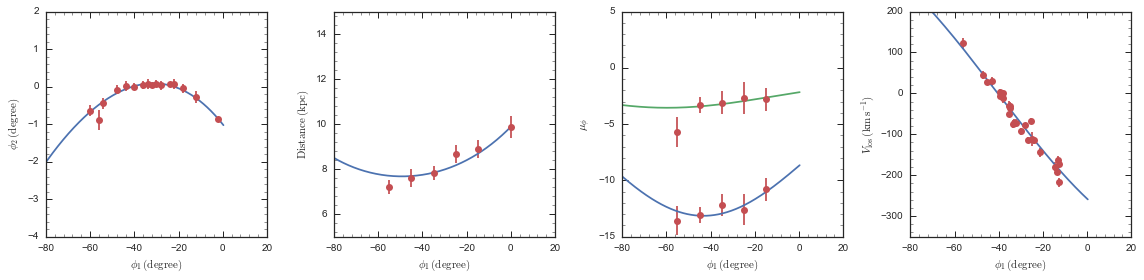

In [8]:
figsize(16,4)
subplot(1,4,1)
plot(track_phi[:,0],track_phi[:,1])
subplot(1,4,2)
plot(track_phi[:,0],track_phi[:,2])
subplot(1,4,3)
plot(track_phi[:,0],track_phi[:,4])
plot(track_phi[:,0],track_phi[:,5])
subplot(1,4,4)
plot(track_phi[:,0],track_phi[:,3])
plot_data_add_labels()
tight_layout()

## The orbit of GD-1 in different flattened and triaxial potentials

In [9]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    print IOError("Need to calculate best-fit potentials for different c in MWPotential2014-varyc.ipynb first")
bf_params= numpy.array(bf_params)
bf_params= bf_params[cs <= 3.]
cs= cs[cs <= 3.]

Changing the flattening $c$ of the dark-matter halo:

In [10]:
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
for bp,c in zip(bf_params,cs):
    pot= MWPotential2014Likelihood.setup_potential(p_b15,c,False,False,ro,vo)
    prog= Orbit(init_vxvv,lb=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit(init_vxvv,lb=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

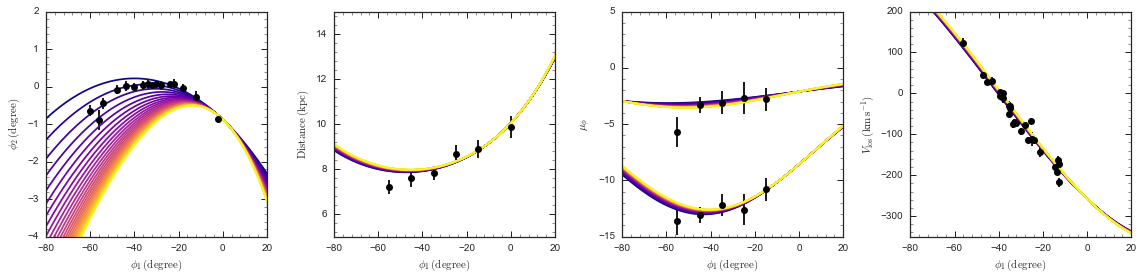

In [11]:
figsize(16,4)
cmap= cm.plasma
for c,orb,orbf in zip(cs,progs,progfs):
    tc= cmap((c-0.5)/2.5)
    for o in [orb,orbf]:
        subplot(1,4,1)
        lls, bbs= o.ll(times), o.bb(times)
        phi12= gd1_util.lb_to_phi12(lls,bbs,degree=True)
        pmphi12= gd1_util.pmllpmbb_to_pmphi12(o.pmll(times),o.pmbb(times),
                                              lls,bbs,degree=True)
        phi12[phi12[:,0] > 180.,0]-= 360.
        plot(phi12[:,0],phi12[:,1],color=tc)
        subplot(1,4,2)
        plot(phi12[:,0],o.dist(times),color=tc)
        subplot(1,4,3)
        plot(phi12[:,0],pmphi12[:,0],color=tc)
        plot(phi12[:,0],pmphi12[:,1],color=tc)
        subplot(1,4,4)
        plot(phi12[:,0],o.vlos(times),color=tc)
plot_data_add_labels(color='k')
#add_colorbar(0.5,3.,r'$c$',save_figures=False)
tight_layout()

Vary $b$ for $c=1$ (pa=0):

In [12]:
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,.6,False,False,ro,vo,b=b)
    prog= Orbit(init_vxvv,lb=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit(init_vxvv,lb=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

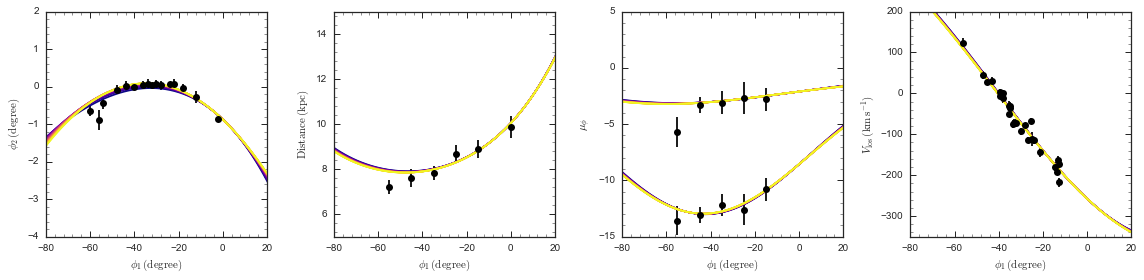

In [13]:
figsize(16,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    for o in [orb,orbf]:
        subplot(1,4,1)
        lls, bbs= o.ll(times), o.bb(times)
        phi12= gd1_util.lb_to_phi12(lls,bbs,degree=True)
        pmphi12= gd1_util.pmllpmbb_to_pmphi12(o.pmll(times),o.pmbb(times),
                                              lls,bbs,degree=True)
        phi12[phi12[:,0] > 180.,0]-= 360.
        plot(phi12[:,0],phi12[:,1],color=tc)
        subplot(1,4,2)
        plot(phi12[:,0],o.dist(times),color=tc)
        subplot(1,4,3)
        plot(phi12[:,0],pmphi12[:,0],color=tc)
        plot(phi12[:,0],pmphi12[:,1],color=tc)
        subplot(1,4,4)
        plot(phi12[:,0],o.vlos(times),color=tc)
plot_data_add_labels(color='k')
#add_colorbar(0.5,3.,r'$c$',save_figures=False)
tight_layout()

Vary $b$ for $c=1$ (pa=45 degree):

In [14]:
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,.6,False,False,ro,vo,b=b,pa=numpy.pi/4.)
    prog= Orbit(init_vxvv,lb=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit(init_vxvv,lb=True,ro=ro,vo=vo,solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

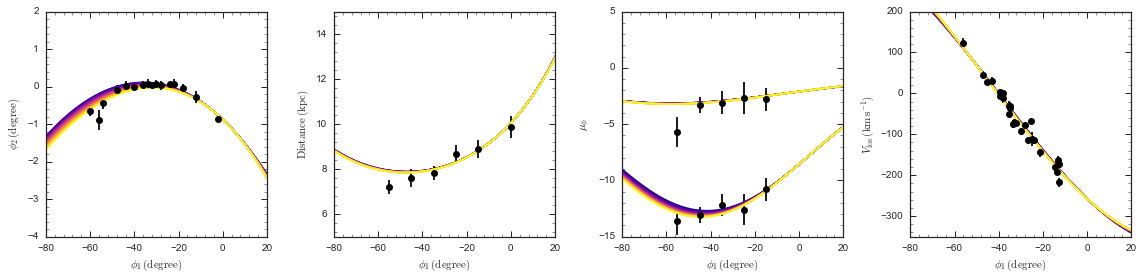

In [15]:
figsize(16,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    for o in [orb,orbf]:
        subplot(1,4,1)
        lls, bbs= o.ll(times), o.bb(times)
        phi12= gd1_util.lb_to_phi12(lls,bbs,degree=True)
        pmphi12= gd1_util.pmllpmbb_to_pmphi12(o.pmll(times),o.pmbb(times),
                                              lls,bbs,degree=True)
        phi12[phi12[:,0] > 180.,0]-= 360.
        plot(phi12[:,0],phi12[:,1],color=tc)
        subplot(1,4,2)
        plot(phi12[:,0],o.dist(times),color=tc)
        subplot(1,4,3)
        plot(phi12[:,0],pmphi12[:,0],color=tc)
        plot(phi12[:,0],pmphi12[:,1],color=tc)
        subplot(1,4,4)
        plot(phi12[:,0],o.vlos(times),color=tc)
plot_data_add_labels(color='k')
#add_colorbar(0.5,3.,r'$c$',save_figures=False)
tight_layout()

The GD-1 stream is not very sensitive to changes in $b$.

# Stream models for GD-1 in flattened halo potentials

## Vary the halo flattening $c$

In [16]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-gd1-varyc.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        gd1varyc= pickle.load(savefile)
else:
    # These values are the best-fit we've found for p_b15
    p= [1.22546174,1.01826231,-0.87622245,1.00457819,-0.07508809,-0.11330589,-0.85817571]
    ro,tvo= _REFR0,p[1]*_REFV0
    pot= MWPotential2014Likelihood.setup_potential(p_b15,p[0],False,False,ro,tvo)
    phi2= p[2]
    dist= p[3]*10.
    pmphi1= -8.5+p[4]
    pmphi2= -2.0+p[5]
    vlos= p[6]*300.
    cs= [0.5,0.75,1.,1.25,1.5,1.75,2.]
    gd1varyc= numpy.zeros((len(cs),track_phi.shape[0],track_phi.shape[1]))
    for ii,c in enumerate(cs):
        print ii, c
        gd1varyc[ii]= gd1_util.predict_gd1obs(p_b15,c,
                                              phi1=0.,phi2=phi2,dist=dist,
                                              pmphi1=pmphi1,pmphi2=pmphi2,vlos=vlos,
                                              ro=ro,vo=tvo,multi=8)[0]
    save_pickles(savefilename,cs,gd1varyc)

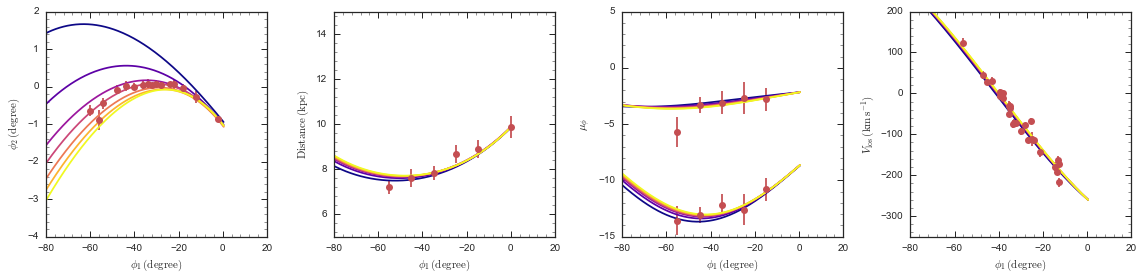

In [17]:
figsize(16,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,4,1)
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,1],color=tc)
    subplot(1,4,2)
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,2],color=tc)
    subplot(1,4,3)
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,4],color=tc)
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,5],color=tc)
    subplot(1,4,4)
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,3],color=tc)
plot_data_add_labels()
tight_layout()

## Vary the normalization of the potential $V_c(R_0)$

In [18]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-gd1-varyvc.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        vcs= pickle.load(savefile)
        gd1varyvc= pickle.load(savefile)
else:
    # These values are the best-fit we've found for p_b15
    p= [1.22546174,1.01826231,-0.87622245,1.00457819,-0.07508809,-0.11330589,-0.85817571]
    ro,tvo= _REFR0,p[1]*_REFV0
    pot= MWPotential2014Likelihood.setup_potential(p_b15,p[0],False,False,ro,tvo)
    phi2= p[2]
    dist= p[3]*10.
    pmphi1= -8.5+p[4]
    pmphi2= -2.0+p[5]
    vlos= p[6]*300.
    vcs= numpy.arange(200.,255.,5.)
    gd1varyvc= numpy.zeros((len(vcs),track_phi.shape[0],track_phi.shape[1]))
    for ii,vc in enumerate(vcs):
        print ii, vc
        isob= None
        if ii == 8: isob= 0.6
        elif ii == 9: isob= 0.5
        elif ii == 10: isob= 0.4
        gd1varyvc[ii]= gd1_util.predict_gd1obs(p_b15,p[0],
                                              phi1=0.,phi2=phi2,dist=dist,
                                              pmphi1=pmphi1,pmphi2=pmphi2,vlos=vlos,
                                              ro=ro,vo=vc,isob=isob,multi=8)[0]
    save_pickles(savefilename,vcs,gd1varyvc)

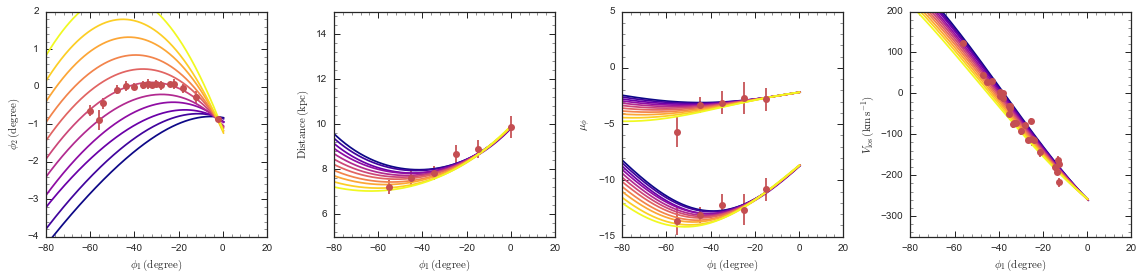

In [19]:
figsize(16,4)
cmap= cm.plasma
for ii, vc in enumerate(vcs):
    tc= cmap((vc-numpy.amin(vcs))/(numpy.amax(vcs)-numpy.amin(vcs)))
    subplot(1,4,1)
    plot(gd1varyvc[ii,:,0],gd1varyvc[ii,:,1],color=tc)
    subplot(1,4,2)
    plot(gd1varyvc[ii,:,0],gd1varyvc[ii,:,2],color=tc)
    subplot(1,4,3)
    plot(gd1varyvc[ii,:500,0],gd1varyvc[ii,:500,4],color=tc)
    plot(gd1varyvc[ii,:500,0],gd1varyvc[ii,:500,5],color=tc)
    subplot(1,4,4)
    plot(gd1varyvc[ii,:,0],gd1varyvc[ii,:,3],color=tc)
plot_data_add_labels()
tight_layout()

### All in one plot

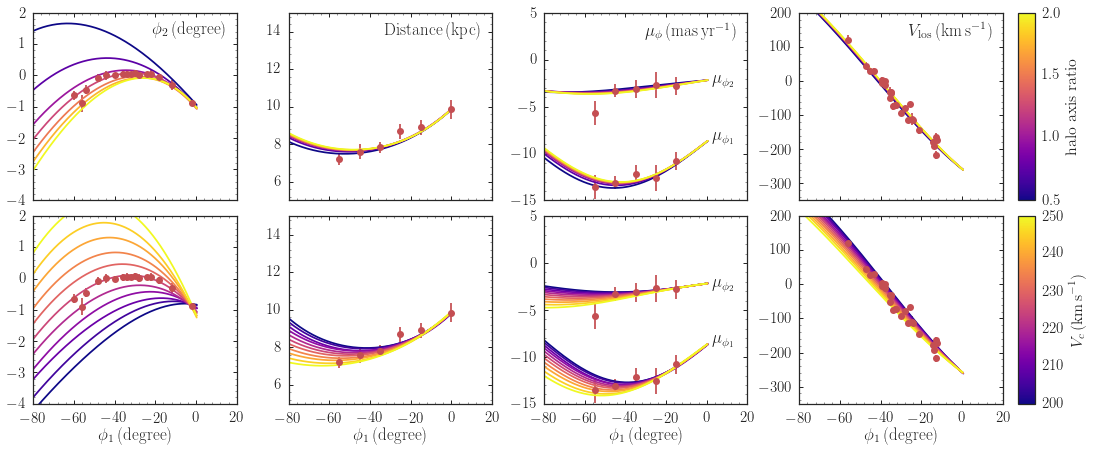

In [20]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(16,7)
cmap= cm.plasma
gs= gridspec.GridSpec(2,4,wspace=0.25,hspace=0.085,width_ratios=[1.,1.,1.,1.,0.075],right=0.98)
# c
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(gs[0])
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,1],color=tc)
    subplot(gs[1])
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,2],color=tc)
    subplot(gs[2])
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,4],color=tc)
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,5],color=tc)
    subplot(gs[3])
    plot(gd1varyc[ii,:,0],gd1varyc[ii,:,3],color=tc)
plot_data_add_labels(p1=(gs[0],),p2=(gs[1],),p3=(gs[2],),p4=(gs[3],),noxlabel=True,ylabel_as_text=True)
# Vc
for ii, vc in enumerate(vcs):
    tc= cmap((vc-numpy.amin(vcs))/(numpy.amax(vcs)-numpy.amin(vcs)))
    subplot(gs[4])
    plot(gd1varyvc[ii,:,0],gd1varyvc[ii,:,1],color=tc)
    subplot(gs[5])
    plot(gd1varyvc[ii,:,0],gd1varyvc[ii,:,2],color=tc)
    subplot(gs[6])
    plot(gd1varyvc[ii,:500,0],gd1varyvc[ii,:500,4],color=tc)
    plot(gd1varyvc[ii,:500,0],gd1varyvc[ii,:500,5],color=tc)
    subplot(gs[7])
    plot(gd1varyvc[ii,:,0],gd1varyvc[ii,:,3],color=tc)
plot_data_add_labels(p1=(gs[4],),p2=(gs[5],),p3=(gs[6],),p4=(gs[7],),noylabel=True)
# Label the proper motions
for tgs in [gs[2],gs[6]]:
    subplot(tgs)
    bovy_plot.bovy_text(2.5,-9.,r'$\mu_{\phi_1}$',size=17.)
    bovy_plot.bovy_text(2.5,-3.,r'$\mu_{\phi_2}$',size=17.)
# Colorbars
gs3= gridspec.GridSpec(2,1,wspace=0.,hspace=0.085,left=0.98,right=0.995)
for ii,(label,vals,ticks) in enumerate(zip(\
        [r'$\mathrm{halo\ axis\ ratio}$',r'$V_c\,(\mathrm{km\,s}^{-1})$'],
        [cs,vcs],
        [[0.5,1.,1.5,2.],[200.,210.,220.,230.,240.,250.]])):
    subplot(gs3[ii])
    sm= pyplot.cm.ScalarMappable(cmap=cmap,
                                 norm=pyplot.Normalize(vmin=numpy.amin(vals),vmax=numpy.amax(vals)))
    sm._A = []
    CB1= pyplot.colorbar(sm,orientation='vertical',cax=gca(),ticks=ticks)
    CB1.set_label(label,fontsize=16.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','gd1track.pdf'),
                bbox_inches='tight')

# MCMC results

## The convergence of different walkers for each potential:

In [21]:
def determine_nburn(filename='../gd1_mcmc/mwpot14-0.dat',
                    threshold=0.1,skip=50,
                    return_nsamples=False):
    """Function to detemrine an appropriate nburn for a given chain"""
    # Load the data
    data= numpy.loadtxt(filename,comments='#',delimiter=',')
    lndata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    # Perform a running diff wrt skip less
    diff= (lndata-numpy.roll(lndata,skip,axis=0))
    diff[:skip]= -100. # Make sure it's not within the first hundred
    maxln= numpy.nanmax(lndata)
    try:
        indx= (numpy.fabs(numpy.median(diff,axis=1)) < threshold)\
                       *((maxln-numpy.nanmax(lndata,axis=1)) < 1.25)
        if maxln > -22.5:
            indx*= numpy.std(lndata,axis=1) < 3.
        if return_nsamples:
            return len(data)-numpy.arange(len(lndata))[indx][0]*nwalkers
        else:
            return numpy.arange(len(lndata))[indx][0]*nwalkers
    except IndexError:
        if return_nsamples: return 100.
        else: return numpy.prod(lndata.shape)-100

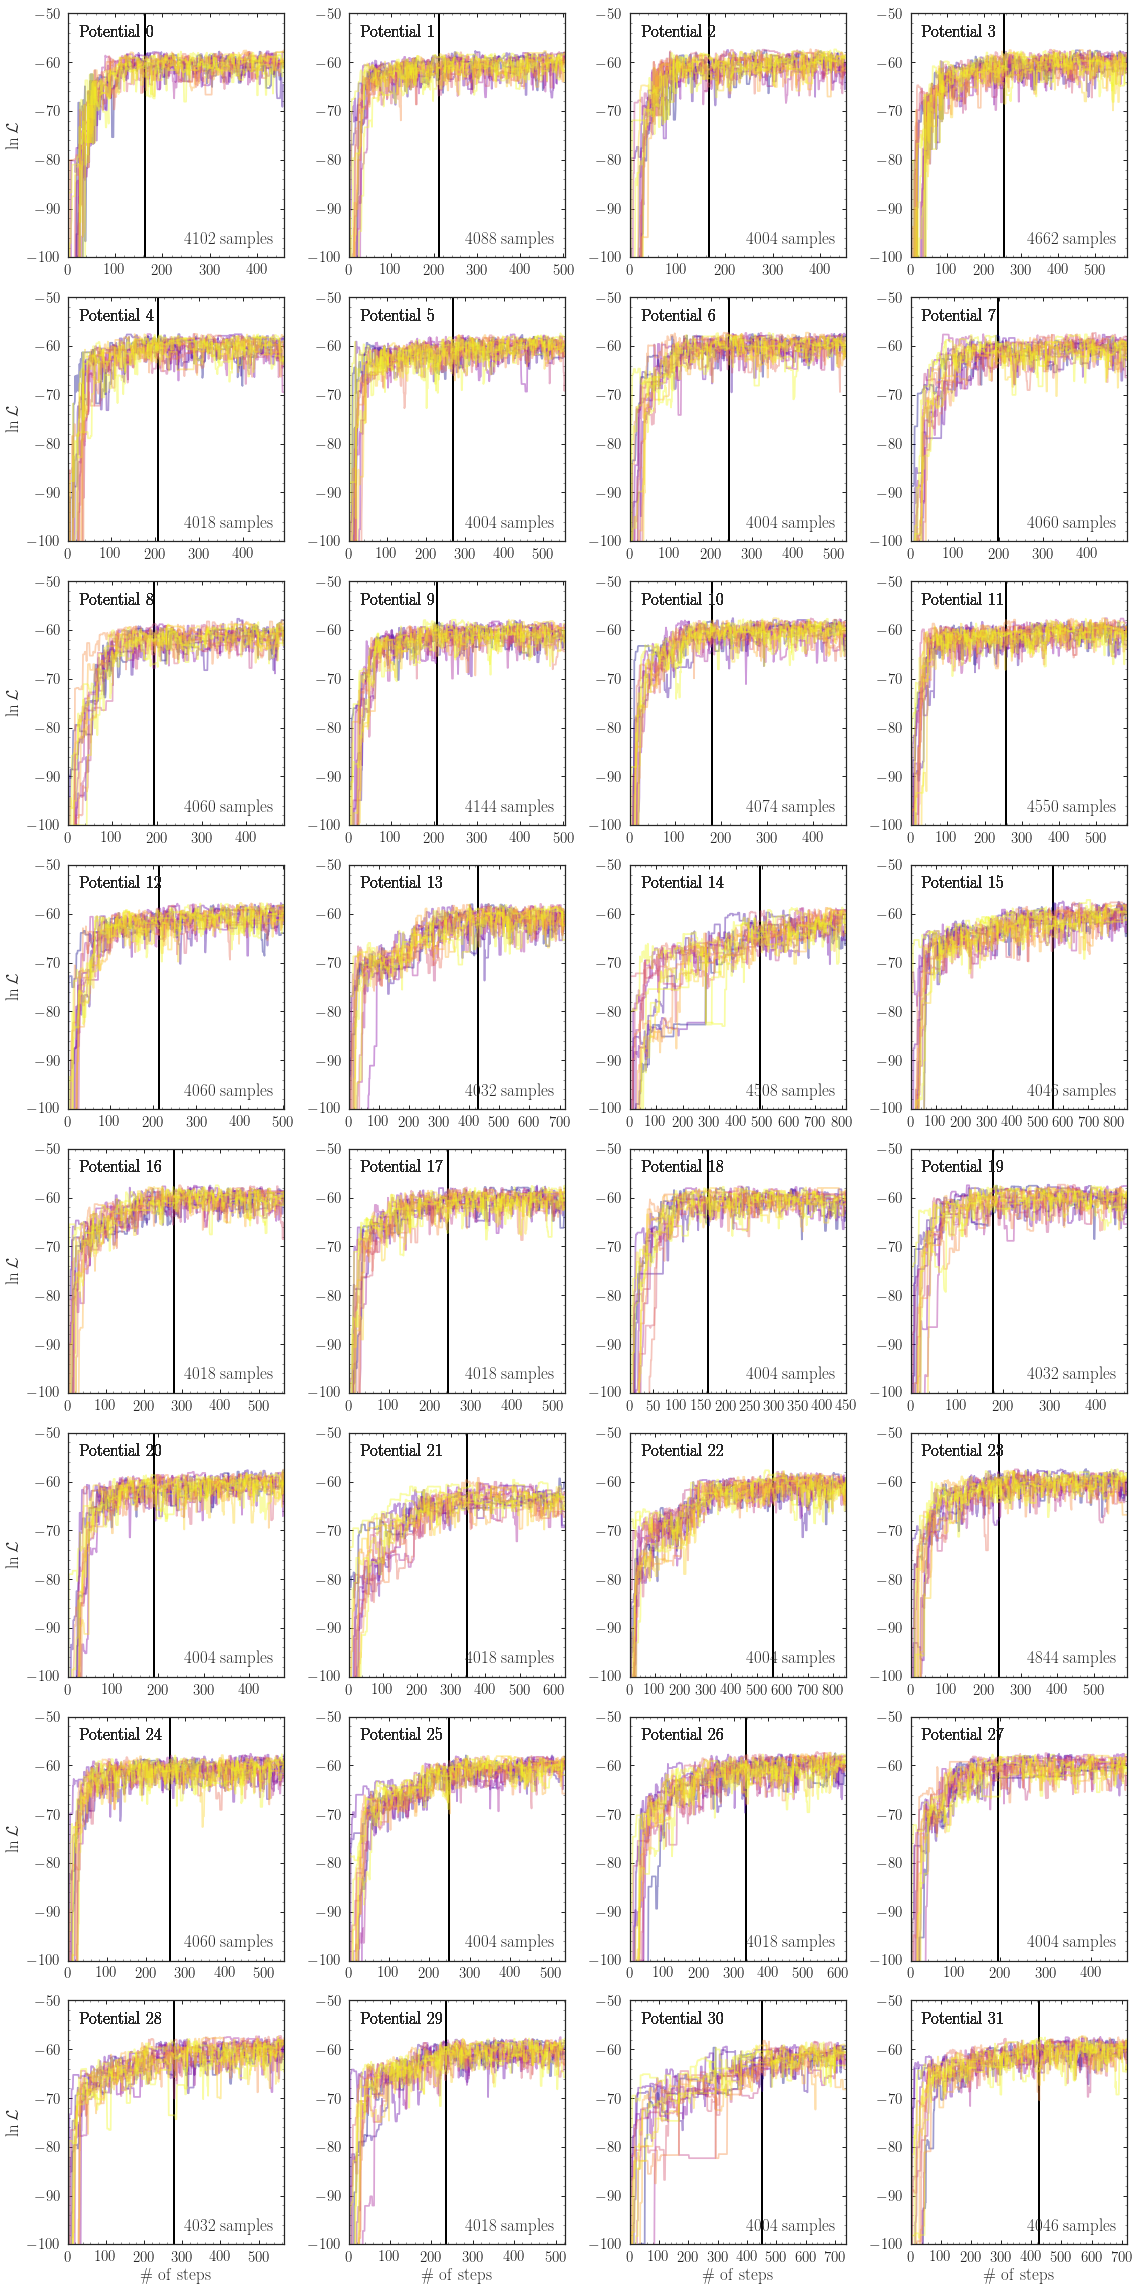

In [22]:
npot= 32
nwalkers= 14
nrow= int(numpy.ceil(npot/4.))
figsize(16,nrow*4)
cmap= cm.plasma
from __builtin__ import range
for en,ii in enumerate(range(npot)):
    fn= '../gd1_mcmc/mwpot14-%i.dat' % ii
    data= numpy.loadtxt(fn,comments='#',delimiter=',')
    subplot(nrow,4,en+1)
    sdata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    for jj in range(nwalkers):
        if ii%4 == 0 and jj == 0:
            tylabel=r'$\ln \mathcal{L}$'
        else:
            tylabel= None
        if ii//4 == nrow-1 and jj == 0:
            txlabel= r'$\#\ \mathrm{of\ steps}$'
        else:
            txlabel= None
        bovy_plot.bovy_plot(1.+numpy.arange(len(sdata[:,jj])),sdata[:,jj],
                            '-',alpha=0.4,
                            color=cmap(jj/11.),
                            yrange=[-100.,-50.],
                            ylabel=tylabel,xlabel=txlabel,
                            gcf=True)
        bovy_plot.bovy_text(r'$\mathrm{Potential}\ %i$' % ii,size=17.,
                            top_left=True)
    nburn= determine_nburn(fn)//nwalkers
    pyplot.axvline(nburn,lw=2.,zorder=1,color='k')
    bovy_plot.bovy_text(r'$%i\ \mathrm{samples}$' % determine_nburn('../gd1_mcmc/mwpot14-%i.dat' % ii,return_nsamples=True),
                       bottom_right=True,size=17.)
tight_layout()

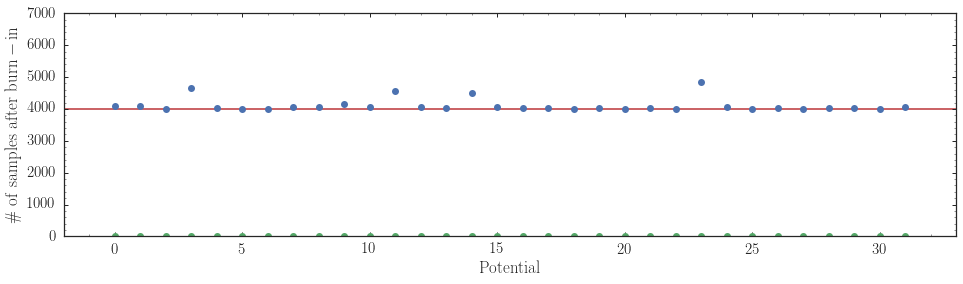

In [23]:
figsize(16,4)
try:
    old_nsamps= copy.deepcopy(nsamps)
except NameError:
    nsamps= numpy.zeros(npot)
    old_nsamps= numpy.zeros(npot)
for en,ii in enumerate(range(npot)):
    fn= '../gd1_mcmc/mwpot14-%i.dat' % ii
    nsamps[en]= determine_nburn(fn,return_nsamples=True)
bovy_plot.bovy_plot(numpy.arange(npot),nsamps,
                   'o',
                    xrange=[-2.,33.],
                    yrange=[0.,7000.],
                    xlabel=r'$\mathrm{Potential}$',
                    ylabel=r'$\#\ \mathrm{of\ samples\ after\ burn-in}$')
bovy_plot.bovy_plot(numpy.arange(npot),old_nsamps,
                   'o',overplot=True)
axhline(4000.,color=sns.color_palette()[2],zorder=0)

In [24]:
nincomp= 0
for ii in range(npot):
    if determine_nburn('../gd1_mcmc/mwpot14-%i.dat' % ii,return_nsamples=True) > 4000: 
        continue
    print ii, nsamps[ii], determine_nburn('../gd1_mcmc/mwpot14-%i.dat' % ii,return_nsamples=True)
    if determine_nburn('../gd1_mcmc/mwpot14-%i.dat' % ii,return_nsamples=True) < 4000.: nincomp+= 1
print "%i/%i remaining ..." % (nincomp,npot)

0/32 remaining ...


In [25]:
determine_nburn('../gd1_mcmc/mwpot14-%i.dat' % 15,return_nsamples=True)

4046

## Resulting PDFs

In [26]:
# Simply copied from pal5Modeling and lightly edited
# Read the necessary data for MWPotential2014Likelihood
reload(MWPotential2014Likelihood)
def evi_harmonic(x):
    # Simple harmonic mean estimator of the evidence, bad!!
    return 1./numpy.mean(numpy.exp(-x[:,-1]))
def evi_laplace(x):
    # Laplace estimator of the evidence
    mindx= numpy.argmax(x[:,-1])
    C= numpy.cov(x[:,:6],rowvar=False)
    return numpy.exp(x[mindx,-1])/numpy.sqrt(numpy.linalg.det(C))
def read_mcmc(filename='../gd1_mcmc/mwpot14-*.dat',nburn=None,
             evi_func=evi_laplace,evi_cut=-10.,
             addforces=False,
             singlepot=None,skip=1):
    fn= glob.glob(filename)
    alldata= numpy.zeros((0,8+2*addforces))
    indx= numpy.zeros((0,1))
    weights= numpy.zeros((0,1))
    evis= numpy.zeros((0,1))
    for f in tqdm(fn):
        if not 'logpot' in f and not 'bf_b15' in f:
            pindx= int(f.split('-')[1].split('.dat')[0])
        else:
            pindx= -1
        #if pindx == 14 or pindx > 27: 
        #    print("Remember: skipping 14 and > 27 for now ...")
        #    continue
        if not singlepot is None and not pindx == singlepot: continue
        try:
            if nburn is None:
                tnburn= determine_nburn(f)
            else:
                 tnburn= nburn   
            tdata= numpy.loadtxt(f,comments='#',delimiter=',')
            tdata= tdata[tnburn::skip]
            tdata= tdata[tdata[:,-1] > numpy.nanmax(tdata[:,-1])+evi_cut]
            if len(tdata) < 100: continue
        except: continue # not enough samples yet
        #Needs to be before addforces, because evi uses -1 as the lnlike index
        tweights= numpy.ones((len(tdata),1))/float(len(tdata))*evi_func(tdata)
        evis= numpy.vstack((evis,numpy.ones((len(tdata),1))*evi_func(tdata)))
        if addforces:
            # Read the potential from the file
            with open(f,'rb') as savefile:
                line1= savefile.readline()
            potparams= [float(s) for s in (line1.split(':')[1].split(','))]
            forces= numpy.empty((len(tdata),2))
            for ee,c in enumerate(tdata[:,0]):
                tvo= tdata[ee,1]*pal5_util._REFV0
                if not 'logpot' in f:
                    pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,
                                                                   pal5_util._REFR0,tvo)
                else:
                    pot= LogarithmicHaloPotential(normalize=1.,q=c)
                forces[ee,:]= MWPotential2014Likelihood.force_gd1(pot,ro,tvo)[:2]
            tdata= numpy.hstack((tdata,forces))
        # Only keep 
        alldata= numpy.vstack((alldata,tdata))
        indx= numpy.vstack((indx,numpy.zeros((len(tdata),1),dtype='int')+pindx))
        weights= numpy.vstack((weights,tweights))
    return (alldata,indx[:,0],weights[:,0],evis[:,0]) 
def plot_corner(alldata,weights=None,addvcprior=False,addforces=False):
    alldata= copy.deepcopy(alldata)
    weights= copy.deepcopy(weights)
    # First adjust for factors
    alldata[:,1]*= pal5_util._REFV0
    if addvcprior:
        weights*= numpy.exp(-0.5*(alldata[:,1]-220.)**2./100.)
    alldata[:,3]*= 10.
    alldata[:,6]*= 300.
    trange= [(0.5,1.5),(200.,250.),(-1.3,-0.7),(9.,11.),
             (-1.,1.),(-1.,1.),(-300.,-200.)]     
    if numpy.any(alldata[:,1] < 200.): # for logpot
        trange[1]= (160.,250.)
    labels= [r'$c$',r'$V_c(R_0)$',r'$\phi_2$',r'$D_{\mathrm{GD-1}}$',
             r'$\mu_{\phi_1}$',r'$\mu_{\phi_2}$',r'$V_{\mathrm{los}}$']
    if addforces or alldata.shape[1] == 10: # forces, don't plot likelihood
        alldata= alldata[:,[0,1,2,3,4,5,6,8,9]]
        trange.extend([(-3.5,-1.5),(-2.7,-0.7)])
        labels.extend([r'$F_{R,\mathrm{GD-1}}$',r'$F_{Z,\mathrm{GD-1}}$'])
    else: # no forces, plot likelihood as well
        alldata= alldata[:,:8]
        trange.append((-70.,-58.))
        labels.append(r'$\ln \mathcal{L}$')
    alldata[numpy.isnan(alldata)]= -1000000000.
    corner.corner(alldata,quantiles=[0.16,0.5,0.84],range=trange,weights=weights,
                  labels=labels,show_titles=True,title_args={"fontsize": 12})

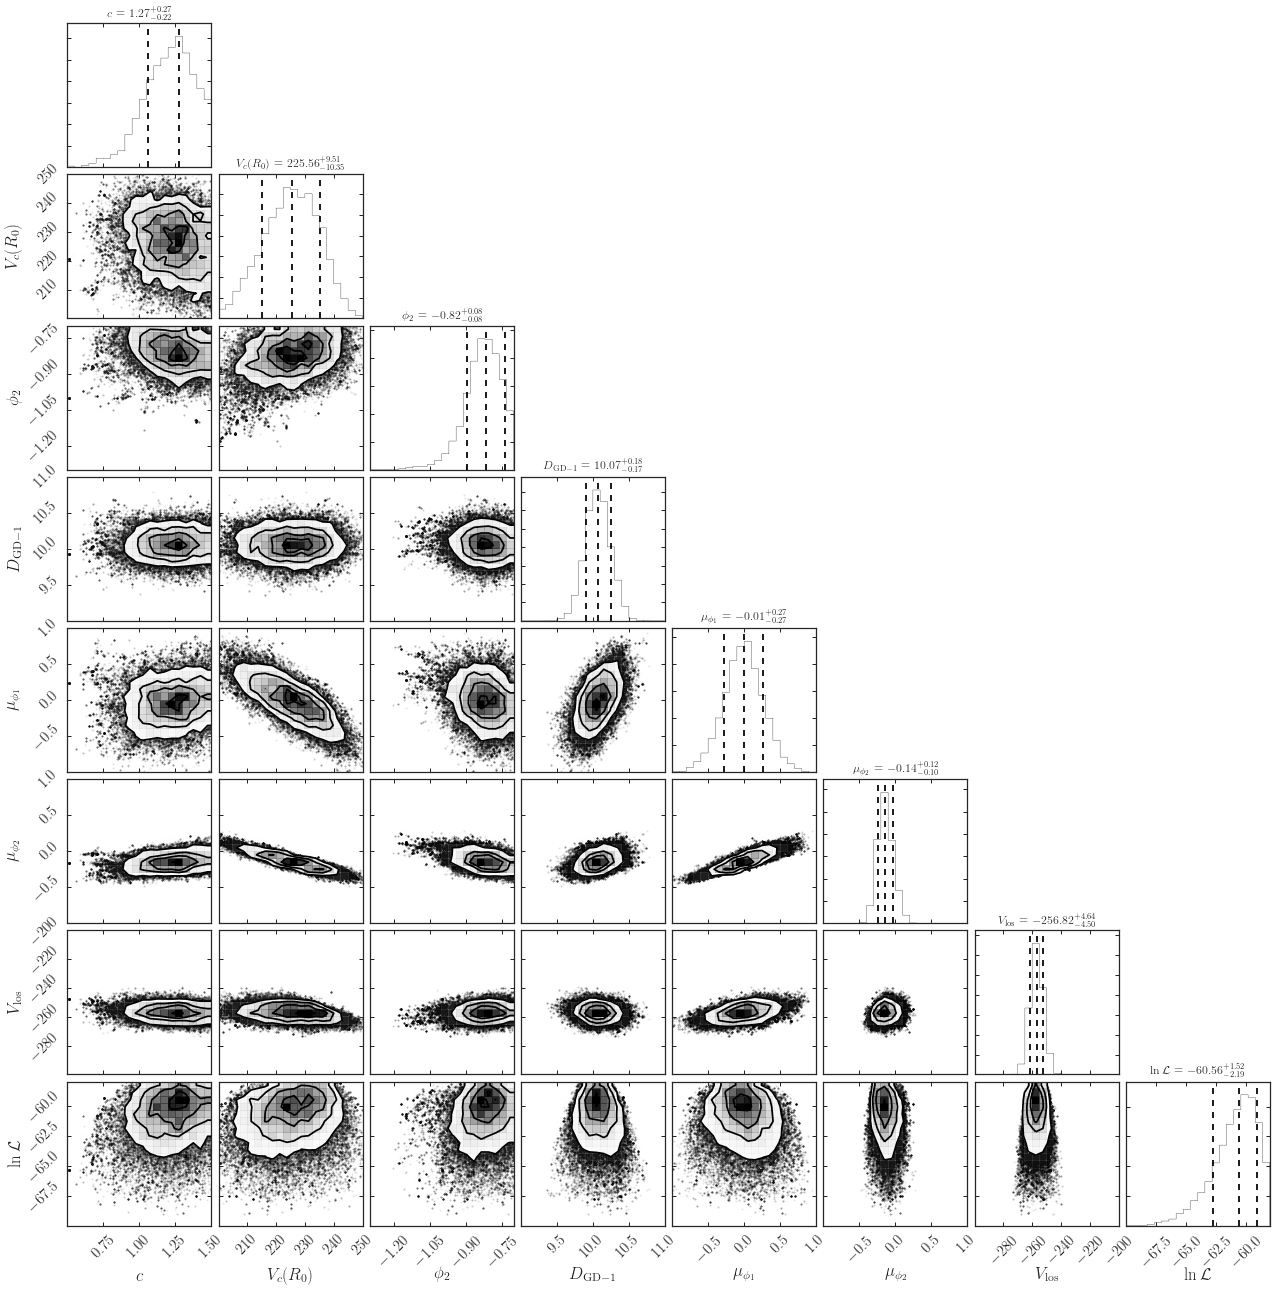

In [27]:
data,_,weights,_= read_mcmc(nburn=None,skip=1,singlepot=None,
                            evi_func=lambda x: 1.,evi_cut=-10.)
#                            evi_func=lambda x: numpy.exp(-25.) if (numpy.log(evi_harmonic(x)) > -25.) else numpy.exp(-50.))
plot_corner(data,weights=weights)

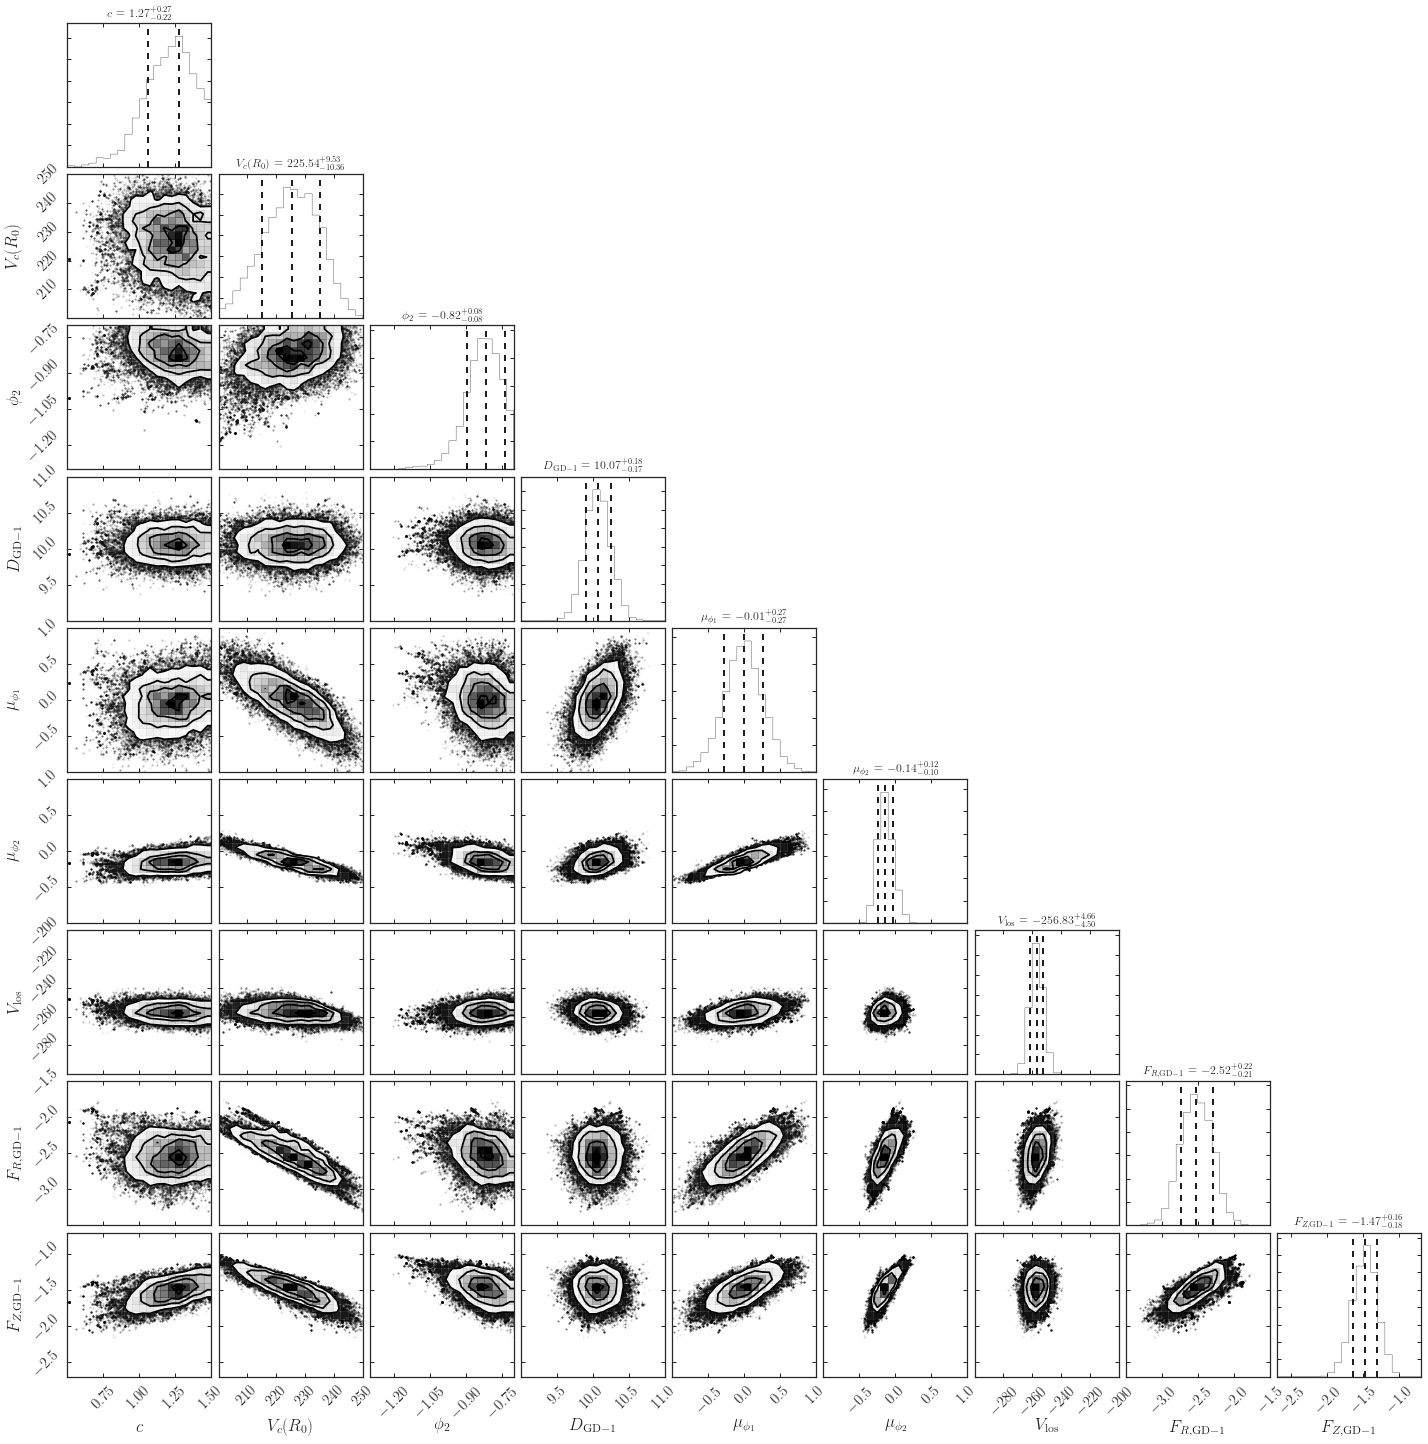

In [28]:
data_wf,index_wf,weights_wf,evi_wf= read_mcmc(nburn=None,
                                      skip=1,addforces=True,
                                      evi_func=lambda x: 1.,evi_cut=-20.)
#                            evi_func=lambda x: numpy.exp(-25.) if (numpy.log(evi_harmonic(x)) > -25.) else numpy.exp(-50.))
plot_corner(data_wf,weights=weights_wf)

The posterior PDF for the potential flattening:

0.955878829069 0.0361470342624


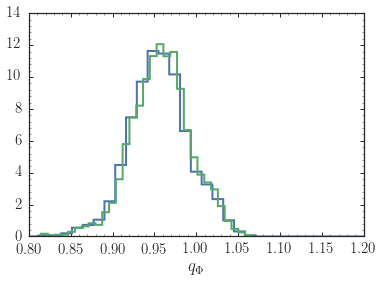

In [29]:
figsize(6,4)
bins= 31
dum= bovy_plot.bovy_hist(numpy.sqrt(6.675/12.5*data_wf[:,-2]/data_wf[:,-1]),weights=weights_wf,
                         histtype='step',lw=2.,bins=bins,
                         xlabel=r'$q_\mathrm{\Phi}$',xrange=[0.8,1.2],normed=True)
dum= bovy_plot.bovy_hist(numpy.sqrt(6.675/12.5*data_wf[:,-2]/data_wf[:,-1]),
                         weights=weights_wf*numpy.exp(-0.5*(data_wf[:,1]-1.)**2./(10./220.)**2.),
                         bins=bins,histtype='step',lw=2.,normed=True,overplot=True)
mq= numpy.sum(numpy.sqrt(6.675/12.5*data_wf[:,-2]/data_wf[:,-1])*weights_wf)/numpy.sum(weights_wf)
print mq, numpy.sqrt(numpy.sum((numpy.sqrt(6.675/12.5*data_wf[:,-2]/data_wf[:,-1])-mq)**2.*weights_wf)/numpy.sum(weights_wf))

Which potential is preferred?

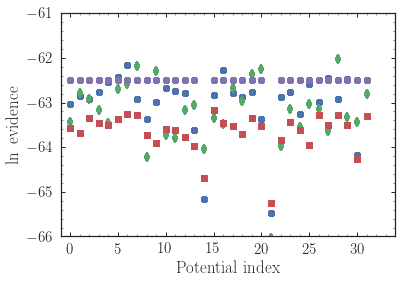

In [30]:
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=evi_harmonic)
figsize(6,4)
bovy_plot.bovy_plot(potindx,numpy.log(evidences),'o',
                    xrange=[-1,34],
                    yrange=[-66,-61],
                   xlabel=r'$\mathrm{Potential\ index}$',
                   ylabel=r'$\ln\ \mathrm{evidence}$')
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=evi_laplace)
bovy_plot.bovy_plot(potindx,numpy.log(evidences)-25.,'d',
                    overplot=True)
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=lambda x: numpy.exp(numpy.amax(x[:,-1])))
bovy_plot.bovy_plot(potindx,numpy.log(evidences)-6.,'s',
                    overplot=True)
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=lambda x: numpy.exp(-62.5) if (numpy.log(evi_harmonic(x)) > -65.) else numpy.exp(-50.))
bovy_plot.bovy_plot(potindx,numpy.log(evidences),'o',
                    overplot=True)

All of the potentials do an almost equally good job of fitting the stream.

## Look at the results for individual potentials

### The flattening $c$

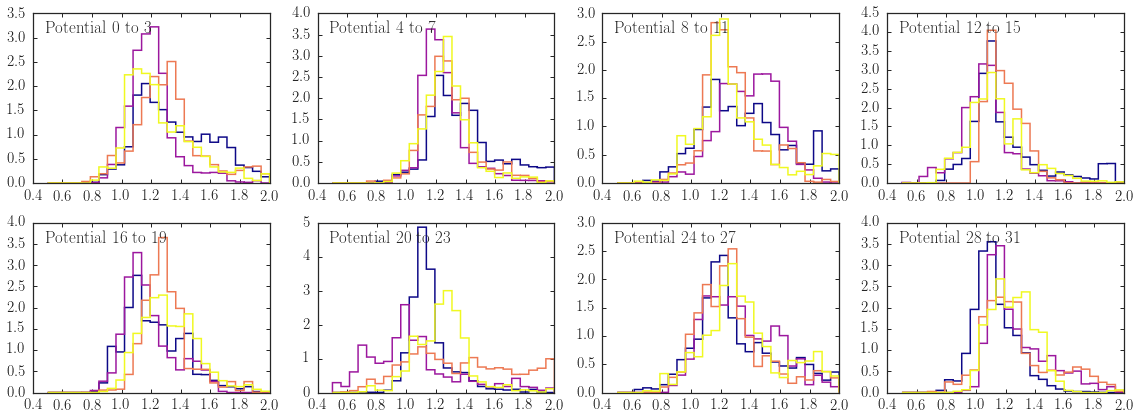

In [31]:
figsize(16,6)
cmap= cm.plasma
maxl= numpy.zeros((npot,2))
for en,ii in enumerate(range(npot)):
    data_ip,_,weights_ip,evi_ip= read_mcmc(singlepot=ii,evi_func=evi_harmonic,nburn=1)
    try:
        maxl[en,0]= numpy.amax(data_ip[:,-1])
        maxl[en,1]= numpy.log(evi_ip[0])
    except ValueError:
        maxl[en]= -10000000.
    subplot(2,4,en//4+1)
    bovy_plot.bovy_hist(data_ip[:,0],range=[0.5,2.],bins=26,
                        histtype='step',color=cmap((en%4)/3.),
                        normed=True,xlabel=r'$c$',lw=1.5,
                        overplot=True)
    if en%4 == 0:
        bovy_plot.bovy_text(r'$\mathrm{Potential\ %i\ to\ % i}$' % (en,en+3),size=17.,
                            top_left=True)
tight_layout()

## What is the effective prior in $(F_R,F_Z)$?

In [32]:
frfzprior_savefilename= 'frfzprior-gd1.pkl'
if not os.path.exists(frfzprior_savefilename):
    # Compute for each potential separately
    nvoc= 10000
    ro= 8.
    npot= 32
    fs= numpy.zeros((2,nvoc,npot))
    for en,ii in tqdm(enumerate(range(npot))):
        fn= '../gd1_mcmc/mwpot14-%i.dat' % ii
        # Read the potential parameters
        with open(fn,'rb') as savefile:
            line1= savefile.readline()
        potparams= [float(s) for s in (line1.split(':')[1].split(','))]
        for jj in range(nvoc):
            c= numpy.random.uniform()*1.5+0.5
            tvo= numpy.random.uniform()*50.+200.
            pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
            fs[:,jj,ii]= numpy.array(MWPotential2014Likelihood.force_gd1(pot,ro,tvo))[:2]
    save_pickles(frfzprior_savefilename,fs)
else:
    with open(frfzprior_savefilename,'rb') as savefile:
        fs= pickle.load(savefile)

/Users/bovy/Repos/galpy/galpy/util/bovy_plot.py:994: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if not weights == None:



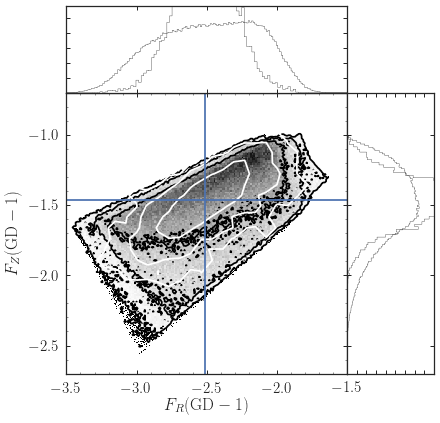

In [33]:
figsize(6,6)
bovy_plot.scatterplot(fs[0].flatten(),
                      fs[1].flatten(),
                      'k,',
                      xrange=[-3.5,-1.5],
                      yrange=[-2.7,-0.7],
                      xlabel=r'$F_R(\mathrm{GD-1})$',
                      ylabel=r'$F_Z(\mathrm{GD-1})$',
                     onedhists=True)
bovy_plot.scatterplot(data_wf[:,8],data_wf[:,9],
                      weights=weights_wf,bins=26,
                      xrange=[-3.5,-1.5],
                      yrange=[-2.7,-0.7],
                      justcontours=True,
                      cntrcolors='w',
                      overplot=True,
                      onedhists=True)
pyplot.axvline(-2.51,color=sns.color_palette()[0])
pyplot.axhline(-1.46,color=sns.color_palette()[0])

The ratio of the posterior and the prior:

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):



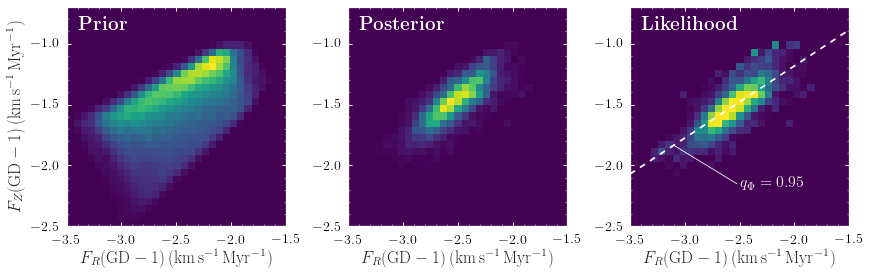

In [34]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12.25,4)
def axes_white():
    for k, spine in gca().spines.items():  #ax.spines is a dictionary
        spine.set_color('w')
    gca().tick_params(axis='x',which='both',colors='w')
    gca().tick_params(axis='y',which='both',colors='w')
    [t.set_color('k') for t in gca().xaxis.get_ticklabels()]
    [t.set_color('k') for t in gca().yaxis.get_ticklabels()]
    return None
bins= 31
trange= [[-3.5,-1.5],[-2.5,-0.7]]
tw= copy.deepcopy(weights_wf)
H_prior, xedges, yedges= numpy.histogram2d(fs[0].flatten(),fs[1].flatten(),bins=bins,range=trange,normed=True)
H_post, xedges, yedges= numpy.histogram2d(data_wf[:,8],data_wf[:,9],weights=tw,
                                          bins=bins,range=trange,normed=True)
H_like= (H_post/H_prior)
H_like[H_prior == 0.]= 0.
subplot(1,3,1)
bovy_plot.bovy_dens2d(H_prior.T,origin='lower',cmap='viridis',
                      interpolation='nearest',
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{GD-1})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',
                      ylabel=r'$F_Z(\mathrm{GD-1})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathbf{Prior}$',top_left=True,size=19.,color='w')
axes_white()
subplot(1,3,2)
bovy_plot.bovy_dens2d(H_post.T,origin='lower',cmap='viridis',
                      interpolation='nearest',
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{GD-1})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathbf{Posterior}$',top_left=True,size=19.,color='w')
axes_white()
subplot(1,3,3)
bovy_plot.bovy_dens2d(H_like.T,origin='lower',cmap='viridis',
                      interpolation='nearest',vmin=0.1,vmax=4.,
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{GD-1})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathbf{Likelihood}$',top_left=True,size=19.,color='w')
axes_white()
def qline(FR,q=0.95):
    return 6.675/12.5*FR/q**2.
q= 0.95
plot([-3.5,-1.5],[qline(-3.5,q=q),qline(-1.5,q=q)],'w--')
bovy_plot.bovy_text(-2.5,-2.2,r'$q_\Phi = 0.95$',size=16.,color='w')
plot((-2.524,-3.1),(-2.15,qline(-3.1,q=q)),'w-',lw=0.8)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','gd1post.pdf'),
                bbox_inches='tight')
tight_layout()

Projection onto the direction perpendicular to constant $q = 0.95$:

-0.0173730062043 0.123213304355


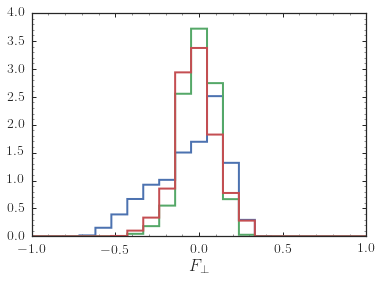

In [35]:
frs= numpy.tile(0.5*(xedges[:-1]+xedges[1:]),(len(yedges)-1,1)).T
fzs= numpy.tile(0.5*(yedges[:-1]+yedges[1:]),(len(xedges)-1,1))
figsize(6,4)
txlabel= r'$F_\perp$'
dum= bovy_plot.bovy_hist((-6.675/12.5*(frs+2.51)+0.95**2.*(fzs+1.47)).flatten(),
                         weights=H_prior.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[-1.,1.],xlabel=txlabel,normed=True)
dum= bovy_plot.bovy_hist((-6.675/12.5*(frs+2.51)+0.95**2.*(fzs+1.47)).flatten(),
                         weights=H_post.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)
dum= bovy_plot.bovy_hist((-6.675/12.5*(frs+2.51)+0.95**2.*(fzs+1.47)).flatten(),
                         weights=H_like.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)
mq= (numpy.sum((-6.675/12.5*(frs+2.51)+0.95**2.*(fzs+1.47)).flatten()*H_like.flatten()))/numpy.sum(H_like.flatten())
print mq, numpy.sqrt((numpy.sum(((-6.675/12.5*(frs+2.51)+0.95**2.*(fzs+1.47)).flatten()-mq)**2.*H_like.flatten()))/numpy.sum(H_like.flatten()))

Projection onto the direction parallel to constant $q = 0.95$:

-0.0550430585761 0.319218081487


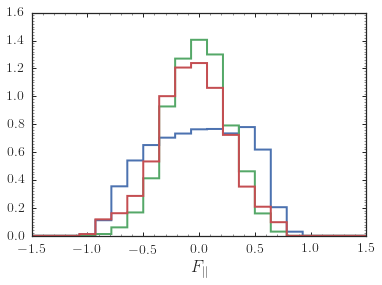

In [36]:
frs= numpy.tile(0.5*(xedges[:-1]+xedges[1:]),(len(yedges)-1,1)).T
fzs= numpy.tile(0.5*(yedges[:-1]+yedges[1:]),(len(xedges)-1,1))
figsize(6,4)
txlabel= r'$F_\parallel$'
dum= bovy_plot.bovy_hist((0.95**2.*(frs+2.51)+6.675/12.5*(fzs+1.47)).flatten(),
                         weights=H_prior.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[-1.5,1.5],xlabel=txlabel,normed=True)
dum= bovy_plot.bovy_hist((0.95**2.*(frs+2.51)+6.675/12.5*(fzs+1.47)).flatten(),
                         weights=H_post.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.5,1.5],normed=True)
dum= bovy_plot.bovy_hist((0.95**2.*(frs+2.51)+6.675/12.5*(fzs+1.47)).flatten(),
                         weights=H_like.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.5,1.5],normed=True)
mq= (numpy.sum((0.95**2.*(frs+2.51)+6.675/12.5*(fzs+1.47)).flatten()*H_like.flatten()))/numpy.sum(H_like.flatten())
print mq, numpy.sqrt((numpy.sum(((0.95**2.*(frs+2.51)+6.675/12.5*(fzs+1.47)).flatten()-mq)**2.*H_like.flatten()))/numpy.sum(H_like.flatten()))

Thus, there is only a weak constraint on $F_R+F_Z$.

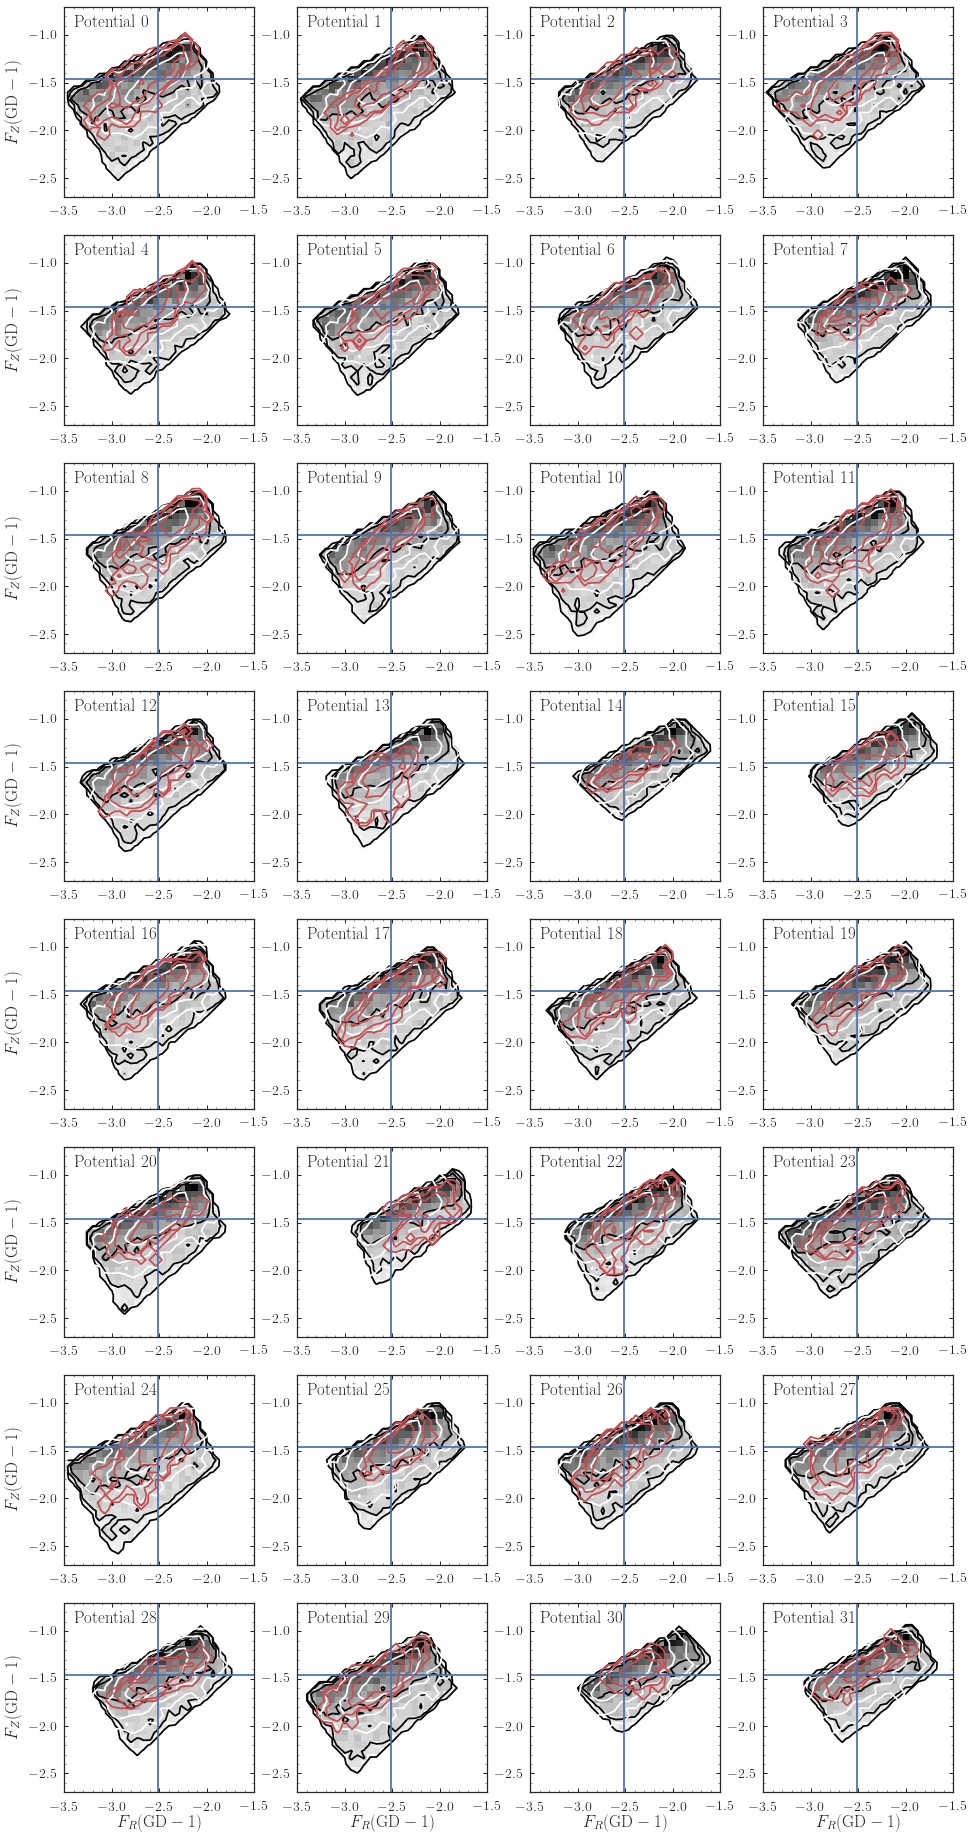

In [37]:
nrow= int(numpy.ceil(npot/4.))
figsize(16,nrow*4)
for en,ii in enumerate(range(npot)):
    subplot(nrow,4,en+1)
    if ii%4 == 0:
        tylabel=r'$F_Z(\mathrm{GD-1})$'
    else:
        tylabel= None
    if ii//4 == nrow-1:
        txlabel= r'$F_R(\mathrm{GD-1})$'
    else:
        txlabel= None
    bovy_plot.scatterplot(fs[0][:,en],fs[1][:,en],
                          'k,',
                          xrange=[-3.5,-1.5],
                      yrange=[-2.7,-0.7],
                          xlabel=txlabel,
                          ylabel=tylabel,
                          gcf=True)
    bovy_plot.scatterplot(data_wf[:,8],data_wf[:,9],
                      weights=weights_wf,bins=26,
                      xrange=[-3.5,-1.5],
                      yrange=[-2.7,-0.7],
                      justcontours=True,
                      cntrcolors='w',
                      overplot=True)
    bovy_plot.scatterplot(data_wf[index_wf == ii,8],
                          data_wf[index_wf == ii,9],
                          weights=weights_wf[index_wf == ii],
                          bins=26,
                          xrange=[-3.5,-1.5],
                          yrange=[-2.7,-0.7],
                          justcontours=True,
                          cntrcolors=sns.color_palette()[2],
                          overplot=True)
    pyplot.axvline(-2.51,color=sns.color_palette()[0])
    pyplot.axhline(-1.46,color=sns.color_palette()[0])
    bovy_plot.bovy_text(r'$\mathrm{Potential}\ %i$' % ii,size=17.,
                        top_left=True)

### What about $q_\Phi$?

From posterior samples: q = 0.956 +/- 0.036
From likelihood of samples: q = 0.954 +/- 0.043


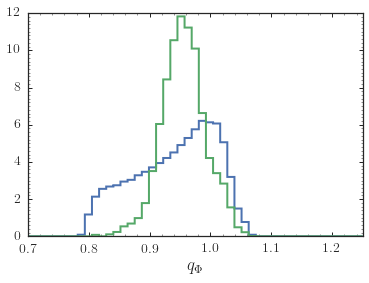

In [38]:
bins= 47
figsize(6,4)
dum= bovy_plot.bovy_hist(numpy.sqrt(6.675/12.5*fs[0].flatten()/fs[1].flatten()),
                         histtype='step',lw=2.,bins=bins,
                         xlabel=r'$q_\mathrm{\Phi}$',xrange=[0.7,1.25],normed=True)
dum= bovy_plot.bovy_hist(numpy.sqrt(6.675/12.5*data_wf[:,-2]/data_wf[:,-1]),weights=weights_wf,
                         histtype='step',lw=2.,bins=bins,
                         overplot=True,xrange=[0.7,1.25],normed=True)
mq= numpy.sum(numpy.sqrt(6.675/12.5*data_wf[:,-2]/data_wf[:,-1])*weights_wf)/numpy.sum(weights_wf)
sq= numpy.sqrt(numpy.sum((numpy.sqrt(6.675/12.5*data_wf[:,-2]/data_wf[:,-1])-mq)**2.*weights_wf)/numpy.sum(weights_wf))
print "From posterior samples: q = %.3f +/- %.3f" % (mq,sq)
Hq_post, xedges= numpy.histogram(numpy.sqrt(6.675/12.5*data_wf[:,-2]/data_wf[:,-1]),
                                 weights=weights_wf,
                                 bins=bins,range=[0.7,1.25],normed=True)
Hq_prior, xedges= numpy.histogram(numpy.sqrt(6.675/12.5*fs[0].flatten()/fs[1].flatten()),
                                 bins=bins,range=[0.7,1.25],normed=True)
qs= 0.5*(xedges[:-1]+xedges[1:])
Hq_like= Hq_post/Hq_prior
Hq_like[Hq_post == 0.]= 0.
mq= numpy.sum(qs*Hq_like)/numpy.sum(Hq_like)
sq= numpy.sqrt(numpy.sum((qs-mq)**2.*Hq_like)/numpy.sum(Hq_like))
print "From likelihood of samples: q = %.3f +/- %.3f" % (mq,sq)

It appears that $q_\Phi$ is the quantity that is the most strongly constrained by the GD-1 data.

## A sampling of tracks from the MCMC

In [39]:
savefilename= 'mwpot14-gd1-mcmcTracks.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        gd1_track_samples= pickle.load(savefile)
        forces= pickle.load(savefile)
        all_potparams= pickle.load(savefile)
        all_params= pickle.load(savefile)
else:
    numpy.random.seed(1)
    ntracks= 21
    multi= 1
    gd1_track_samples= numpy.zeros((ntracks,6,gd1varyc[0].shape[0]))
    forces= numpy.zeros((ntracks,2))
    all_potparams= numpy.zeros((ntracks,5))
    all_params= numpy.zeros((ntracks,8))
    for ii in range(ntracks):
        # Pick a random potential from among the set
        pindx= -1
        while pindx == -1:
            pindx= numpy.random.permutation(32)[0]
        # Load this potential
        fn= '../gd1_mcmc/mwpot14-%i.dat' % pindx
        with open(fn,'rb') as savefile:
            line1= savefile.readline()
        potparams= [float(s) for s in (line1.split(':')[1].split(','))]
        all_potparams[ii]= potparams
        # Now pick a random sample from this MCMC chain
        tnburn= determine_nburn(fn)
        tdata= numpy.loadtxt(fn,comments='#',delimiter=',')
        tdata= tdata[tnburn::]
        tdata= tdata[numpy.random.permutation(len(tdata))[0]]
        all_params[ii]= tdata
        tvo= tdata[1]*_REFV0
        pot= MWPotential2014Likelihood.setup_potential(potparams,tdata[0],False,False,
                                                       pal5_util._REFR0,tvo)
        forces[ii,:]= MWPotential2014Likelihood.force_gd1(pot,ro,tvo)[:2]
        # Now compute the stream model for this setup
        phi2= tdata[2]
        dist= tdata[3]*10.
        pmphi1= -8.5+tdata[4]
        pmphi2= -2.0+tdata[5]
        vlos= tdata[6]*300.
        prog= Orbit(gd1_util.phi12_to_lb_6d(0.,phi2,dist,pmphi1,pmphi2,vlos),
                    lb=True,ro=ro,vo=tvo,solarmotion=[-11.1,24.,7.25])
        sdf= gd1_util.setup_sdf(pot,prog,0.4,10.,
                                ro,tvo,multi=multi,
                                nTrackChunks=8,
                                trailing_only=True,
                                verbose=True,
                                useTM=False)
        # Compute the track
        track_phi= gd1_util.convert_track_lb_to_phi12(sdf._interpolatedObsTrackLB)
        # Store the track
        gd1_track_samples[ii]= track_phi.T
    save_pickles(savefilename,gd1_track_samples,forces,all_potparams,all_params)

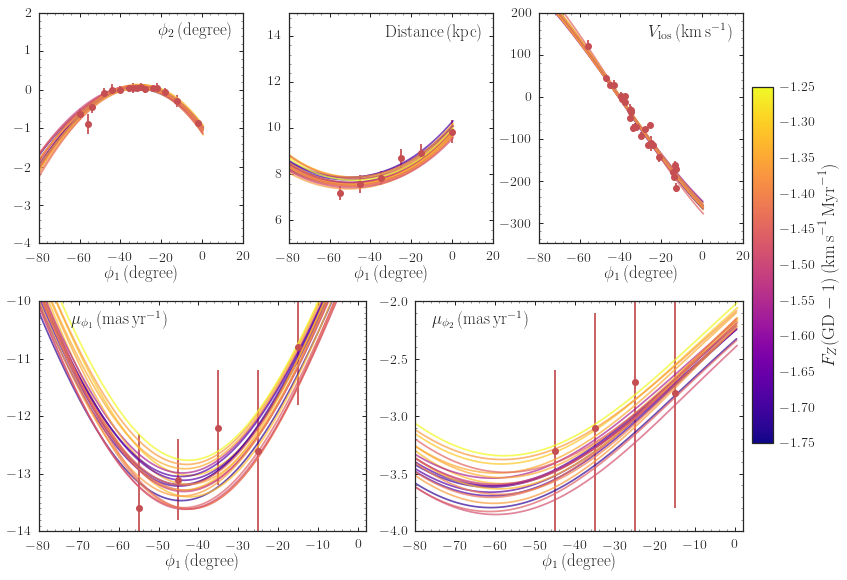

In [40]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(12,8)
gs= gridspec.GridSpec(1,3,wspace=0.225,hspace=0.1,right=0.94,bottom=0.55,top=.95)
gs2= gridspec.GridSpec(1,2,wspace=0.15,hspace=0.1,right=0.94,bottom=0.05,top=0.45)
ntracks= gd1_track_samples.shape[0]
cmap= cm.plasma
alpha= 0.7
for ii in range(ntracks):
    tc= cmap((forces[ii,1]+1.75)/0.5)
    # phi1,phi2
    subplot(gs[0])
    plot(gd1_track_samples[ii,0],gd1_track_samples[ii,1],'-',color=tc,alpha=alpha)
    # RA, Dist
    subplot(gs[1])
    plot(gd1_track_samples[ii,0],gd1_track_samples[ii,2],'-',color=tc,alpha=alpha)
    # RA, Vlos
    subplot(gs[2])
    plot(gd1_track_samples[ii,0],gd1_track_samples[ii,3],'-',color=tc,alpha=alpha)
    # RA, pm_phi1
    subplot(gs2[0])
    plot(gd1_track_samples[ii,0,:500],gd1_track_samples[ii,4,:500],
         '-',color=tc,alpha=alpha)
    # RA, pm_phi2
    subplot(gs2[1])
    plot(gd1_track_samples[ii,0,:500],gd1_track_samples[ii,5,:500],
         '-',color=tc,alpha=alpha)
plot_data_add_labels(p1=(gs[0],),p2=(gs[1],),p4=(gs[2],),nopm=True,ylabel_as_text=True)
# Add the proper motion data manually
subplot(gs2[0])
xlabel(r'$\phi_1\,(\mathrm{degree})$')
annotate(r'$\mu_{\phi_1}\,(\mathrm{mas\,yr}^{-1})$',(0.1,0.95),
         xycoords='axes fraction',
         verticalalignment='top',size=17.)
xlim(-80.,2.)
ylim(-14.,-10.)
bovy_plot._add_ticks()
gca().yaxis.set_ticks([-14.,-13.,-12.,-11.,-10.])
errorbar(pmdata[:,0],pmdata[:,1],yerr=pmdata[:,3],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(gs2[1])
xlabel(r'$\phi_1\,(\mathrm{degree})$')
bovy_plot.bovy_text(r'$\mu_{\phi_2}\,(\mathrm{mas\,yr}^{-1})$',top_left=True,size=17.)
xlim(-80.,2.)
ylim(-4.,-2.)
bovy_plot._add_ticks()
errorbar(pmdata[:,0],pmdata[:,2],yerr=pmdata[:,3],
         ls='none',marker='o',color=sns.color_palette()[2])
# Colorbar
gs3= gridspec.GridSpec(20,1,wspace=0.225,hspace=0.1,left=0.95,right=0.975)
subplot(gs3[2:18])
sm= pyplot.cm.ScalarMappable(cmap=cmap,
                             norm=pyplot.Normalize(vmin=-1.75,vmax=-1.25))
sm._A = []
CB1= pyplot.colorbar(sm,orientation='vertical',cax=gca())
CB1.set_label(r'$F_Z(\mathrm{GD-1})\,(\mathrm{km\,s}^{-1}\,\mathrm{Myr}^{-1})$',fontsize=18.)
if save_figures:
    plt.savefig(os.path.join(os.getenv('PAPERSDIR'),'2016-mwhalo-shape','gd1tracksamples.pdf'),
                bbox_inches='tight')

# Analysis in a simple flattened logarithmic potential

## $R_0 = 8.0$ kpc

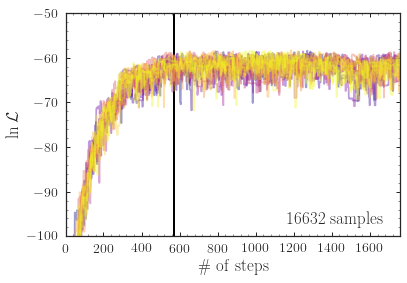

In [41]:
figsize(6,4)
fn= '../gd1_mcmc/logpot.dat'
data= numpy.loadtxt(fn,comments='#',delimiter=',')
sdata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
for jj in range(nwalkers):
    tylabel=r'$\ln \mathcal{L}$'
    txlabel= r'$\#\ \mathrm{of\ steps}$'
    bovy_plot.bovy_plot(1.+numpy.arange(len(sdata[:,jj])),sdata[:,jj],
                        '-',alpha=0.4,
                        color=cmap(jj/11.),
                        yrange=[-100.,-50.],
                        ylabel=tylabel,xlabel=txlabel,gcf=True)
nburn= determine_nburn(fn)//nwalkers
pyplot.axvline(nburn,lw=2.,zorder=1,color='k')
bovy_plot.bovy_text(r'$%i\ \mathrm{samples}$' % determine_nburn('../gd1_mcmc/logpot.dat',
                                                                return_nsamples=True),
                       bottom_right=True,size=17.)

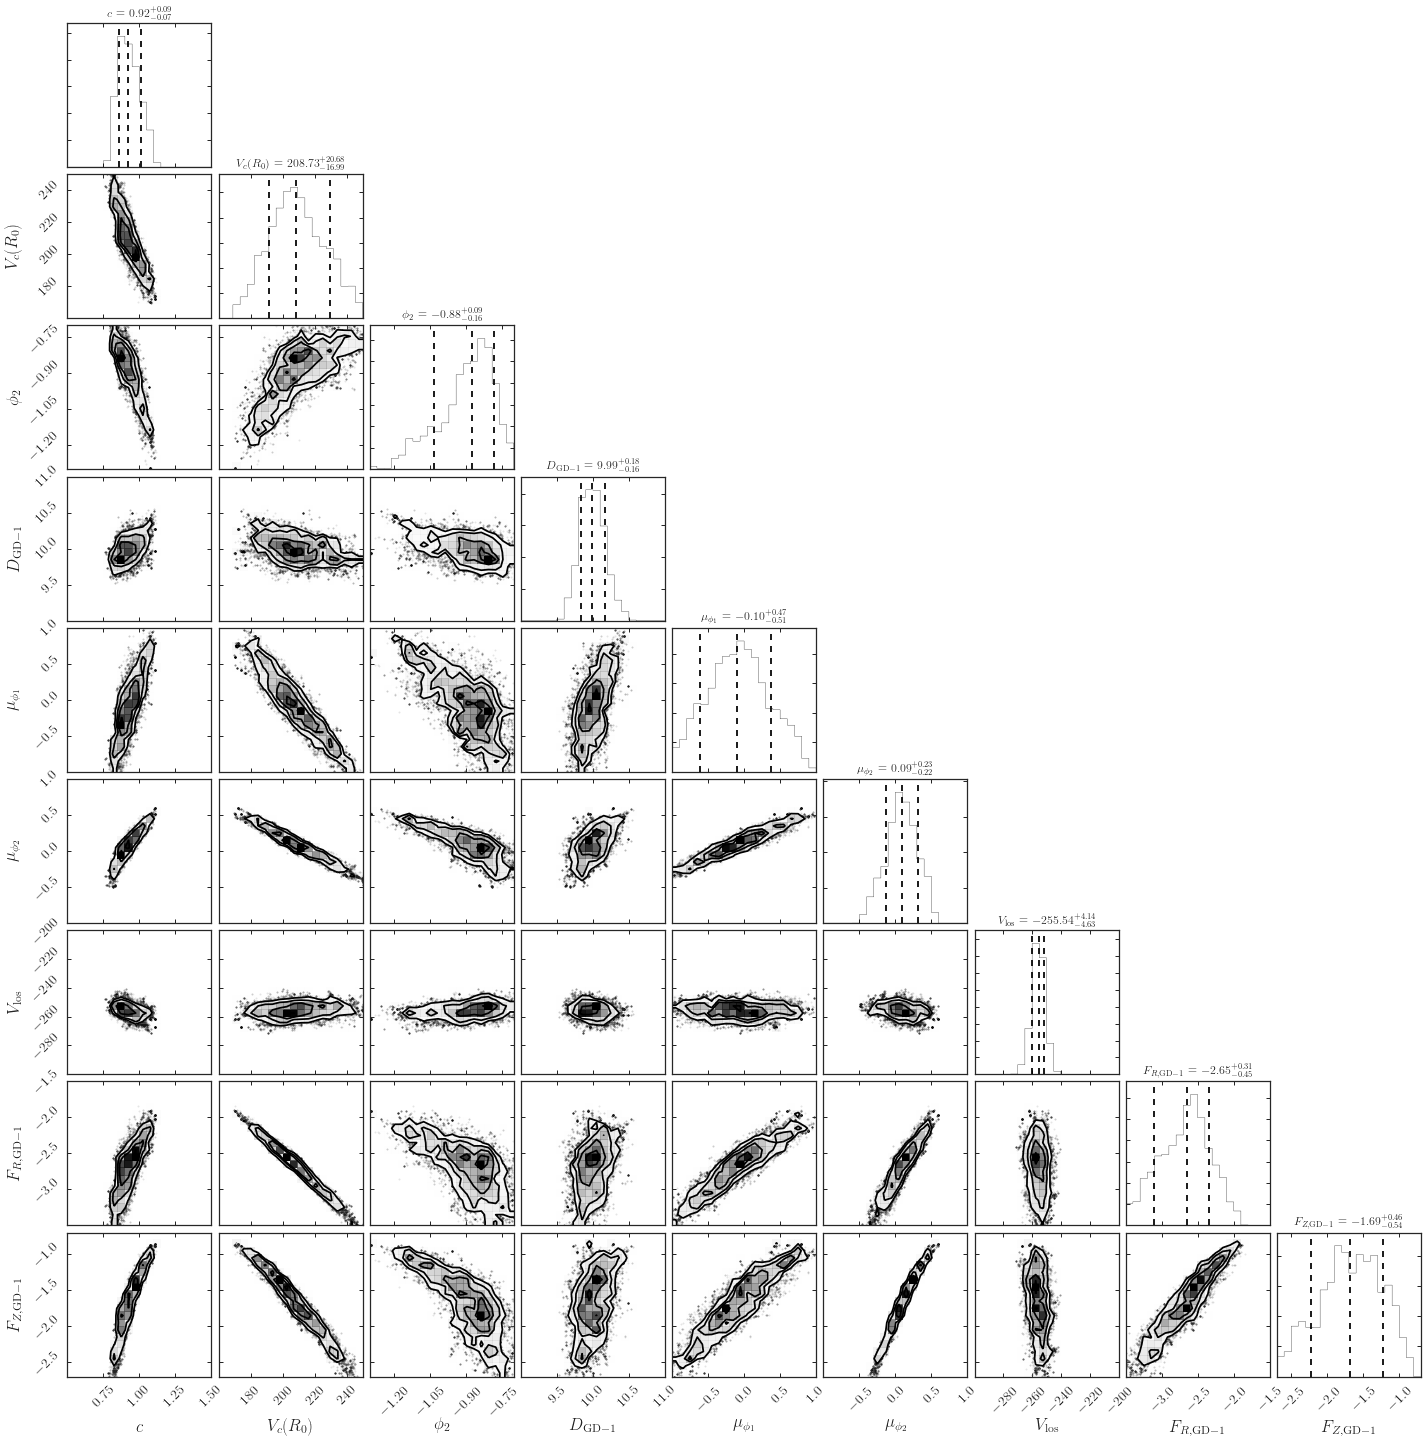

In [42]:
data,_,weights,_= read_mcmc(filename='../gd1_mcmc/logpot.dat',
                            nburn=None,singlepot=None,
                            addforces=True,skip=1,
                            evi_func=lambda x: 1.,evi_cut=-10.)
#                            evi_func=lambda x: numpy.exp(-25.) if (numpy.log(evi_harmonic(x)) > -25.) else numpy.exp(-50.))
plot_corner(data,weights=weights)

0.931635709042 0.0731571952009


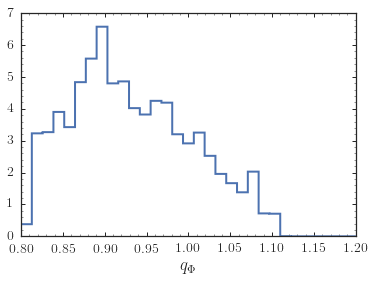

In [43]:
figsize(6,4)
bins= 31
dum= bovy_plot.bovy_hist(numpy.sqrt(6.675/12.5*data[:,-2]/data[:,-1]),weights=weights,
                         histtype='step',lw=2.,bins=bins,
                         xlabel=r'$q_\mathrm{\Phi}$',xrange=[0.8,1.2],normed=True)
mq= numpy.sum(numpy.sqrt(6.675/12.5*data[:,-2]/data[:,-1])*weights)/numpy.sum(weights)
print mq, numpy.sqrt(numpy.sum((numpy.sqrt(6.675/12.5*data[:,-2]/data[:,-1])-mq)**2.*weights)/numpy.sum(weights))

## $R_0 = 8.5$ kpc

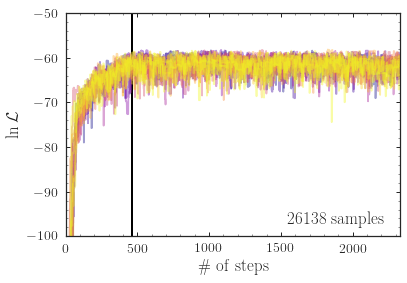

In [44]:
figsize(6,4)
fn= '../gd1_mcmc/logpot-r08p5.dat'
data= numpy.loadtxt(fn,comments='#',delimiter=',')
sdata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
for jj in range(nwalkers):
    tylabel=r'$\ln \mathcal{L}$'
    txlabel= r'$\#\ \mathrm{of\ steps}$'
    bovy_plot.bovy_plot(1.+numpy.arange(len(sdata[:,jj])),sdata[:,jj],
                        '-',alpha=0.4,
                        color=cmap(jj/11.),
                        yrange=[-100.,-50.],
                        ylabel=tylabel,xlabel=txlabel,gcf=True)
nburn= determine_nburn(fn)//nwalkers
pyplot.axvline(nburn,lw=2.,zorder=1,color='k')
bovy_plot.bovy_text(r'$%i\ \mathrm{samples}$' % determine_nburn('../gd1_mcmc/logpot-r08p5.dat',
                                                                return_nsamples=True),
                       bottom_right=True,size=17.)

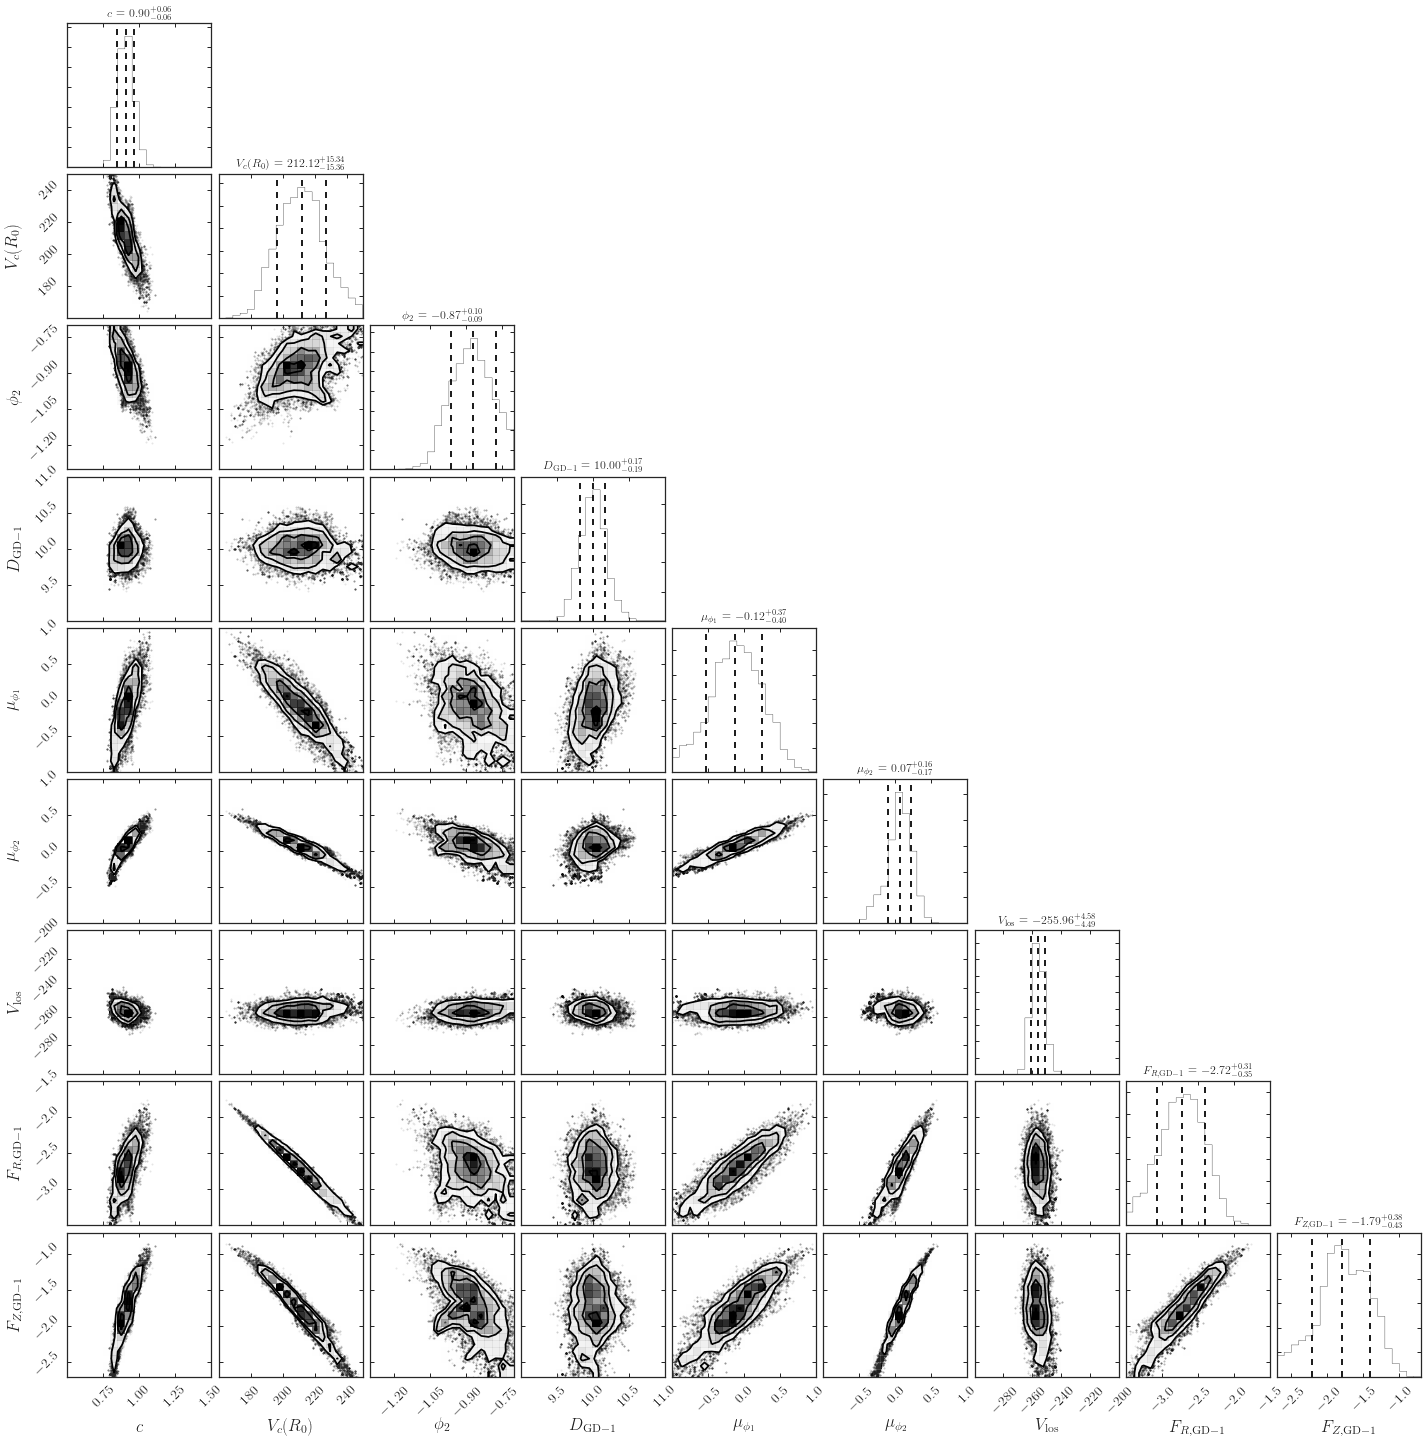

In [45]:
data,_,weights,_= read_mcmc(filename='../gd1_mcmc/logpot-r08p5.dat',
                            nburn=1,skip=1,singlepot=None,addforces=True,
                            evi_func=lambda x: 1.,evi_cut=-10.)
#                            evi_func=lambda x: numpy.exp(-25.) if (numpy.log(evi_harmonic(x)) > -25.) else numpy.exp(-50.))
plot_corner(data,weights=weights)

0.906022414442 0.0548406960256


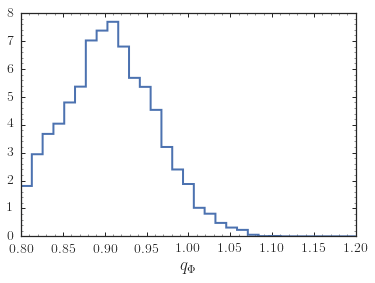

In [46]:
figsize(6,4)
bins= 31
dum= bovy_plot.bovy_hist(numpy.sqrt(6.675/12.5*data[:,-2]/data[:,-1]),weights=weights,
                         histtype='step',lw=2.,bins=bins,
                         xlabel=r'$q_\mathrm{\Phi}$',xrange=[0.8,1.2],normed=True)
mq= numpy.sum(numpy.sqrt(6.675/12.5*data[:,-2]/data[:,-1])*weights)/numpy.sum(weights)
print mq, numpy.sqrt(numpy.sum((numpy.sqrt(6.675/12.5*data[:,-2]/data[:,-1])-mq)**2.*weights)/numpy.sum(weights))